<a href="https://colab.research.google.com/github/dude123studios/AdvancedGenerativeLearning/blob/main/Pix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 679 kB 8.6 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds
from tensorflow_addons.layers import InstanceNormalization

import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
_URL = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 7s 0us/step


In [4]:
image_shape = (256, 256, 3)
IMG_HEIGHT = image_shape[0]
IMG_WIDTH = image_shape[1]

In [5]:
BATCH_SIZE = 32
BUFFER_SIZE = 400

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(5).repeat()

In [6]:
def downsample(channels, kernels, strides=2, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                                use_bias=False, kernel_initializer=initializer))
    
    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

def upsample(channels, kernels, strides=1, norm=True, activation=True, dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    block = tf.keras.Sequential()
    block.add(layers.UpSampling2D((2,2)))
    block.add(layers.Conv2D(channels, kernels, strides=strides, padding='same', 
                            use_bias=False, kernel_initializer=initializer))

    if norm:
        block.add(InstanceNormalization())              
    if activation:
        block.add(layers.LeakyReLU(0.2)) 
    if dropout:
        block.add(layers.Dropout(0.5))

    return block

In [7]:
def build_generator():

    DIM = 64
    input_image = layers.Input(shape=image_shape)
    down1 = downsample(DIM, 4, norm=False)(input_image)
    down2 = downsample(2 * DIM, 4, norm=False)(down1)
    down3 = downsample(4 * DIM, 4, norm=False)(down2)
    down4 = downsample(4 * DIM, 4, norm=False)(down3)
    down5 = downsample(4 * DIM, 4, norm=False)(down4)
    down6 = downsample(4 * DIM, 4, norm=False)(down5)
    down7 = downsample(4 * DIM, 4, norm=False)(down6)

    up6 = upsample(4*DIM, 4, dropout=True)(down7)
    concat6 = layers.Concatenate()([up6, down6]) 

    up5 = upsample(4*DIM, 4, dropout=True)(concat6)
    concat5 = layers.Concatenate()([up5, down5]) 
    
    up4 = upsample(4*DIM, 4)(concat5)
    concat4 = layers.Concatenate()([up4, down4]) 

    up3 = upsample(4*DIM, 4)(concat4)
    concat3 = layers.Concatenate()([up3, down3]) 

    up2 = upsample(2*DIM, 4)(concat3)
    concat2 = layers.Concatenate()([up2, down2]) 

    up1 = upsample(DIM, 4)(concat2)
    concat1 = layers.Concatenate()([up1, down1]) 

    output_image = tanh(upsample(3, 4, norm=False, activation=False)(concat1))

    return Model(input_image, output_image, name='generator') 

In [8]:
def build_discriminator():
    DIM = 64
    model = tf.keras.Sequential(name='discriminators') 
    input_image_A = layers.Input(shape=image_shape)
    input_image_B = layers.Input(shape=image_shape)
        
    x = layers.Concatenate()([input_image_A, input_image_B])
    x = downsample(DIM, 4, norm=False)(x) # 128
    x = downsample(2*DIM, 4)(x) # 64
    x = downsample(4*DIM, 4)(x) # 32
    x = downsample(8*DIM, 4, strides=1)(x) # 29
    output = layers.Conv2D(1, 4, activation='sigmoid')(x)

    return Model([input_image_A, input_image_B], output) 

In [9]:
class Pix2Pix(Model):

    def __init__(self, input_shape):
        super(Pix2Pix, self).__init__()

        self.generator = build_generator()
        self.discriminator = build_discriminator()

        self.LAMBDA = 100

        discriminator_output = self.discriminator([self.generator.input, self.generator.output])
        self.patch_size = discriminator_output.shape[1]

    def compile(self, d_optimizer, g_optimizer, loss_fn=BinaryCrossentropy(), recon_loss_fn = tf.keras.losses.mean_absolute_error):
        super(Pix2Pix, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.recon_loss_fn = recon_loss_fn

    def train_step(self, inputs):
        input_imgs, real_imgs = inputs

        batch_size = tf.shape(input_imgs)[0]
        real_labels = tf.ones((batch_size, self.patch_size, self.patch_size, 1))
        fake_labels = tf.zeros((batch_size, self.patch_size, self.patch_size, 1))

        with tf.GradientTape() as g_tape, \
            tf.GradientTape() as d_tape:

            fake_imgs = self.generator(input_imgs)

            fake_preds = self.discriminator([input_imgs, fake_imgs])
            real_preds = self.discriminator([input_imgs, real_imgs])

            d_loss = 0.5 * (self.loss_fn(real_labels, real_preds) + self.loss_fn(fake_labels, fake_preds))

            g_loss =  (1 / self.LAMBDA) * self.loss_fn(real_labels, fake_preds) + self.recon_loss_fn(real_imgs, fake_imgs)
        
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return {'g_loss': g_loss, 'd_loss': d_loss}
    
    def call(self, input_imgs):
        return self.generator(input_imgs)

In [10]:
class GenerativeCallback(tf.keras.callbacks.Callback):

    def __init__(self, test_dataset, num_imgs=5, interval=5):
        super(GenerativeCallback, self).__init__()
        
        self.num_imgs = num_imgs
        self.interval = interval
        self.ds = iter(test_dataset)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch % self.interval) is not 0:
            return 
        grid_row = 1
        grid_col = self.num_imgs
        batch, _ = next(self.ds)
        images = self.model(batch)
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1.5))
        for col in range(grid_col):
            axarr[col].imshow((images[col,:,:,:]+1)/2)
            axarr[col].axis('off') 
        plt.show()

Epoch 1/50
12/12 [==============================] - 62s 1s/step - g_loss: 0.3923 - d_loss: 0.7845


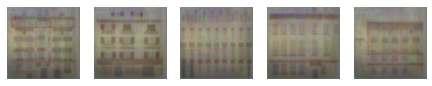

Epoch 2/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3555 - d_loss: 0.6378
Epoch 3/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3525 - d_loss: 0.5562
Epoch 4/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3540 - d_loss: 0.5227
Epoch 5/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3545 - d_loss: 0.3982
Epoch 6/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3576 - d_loss: 0.4497


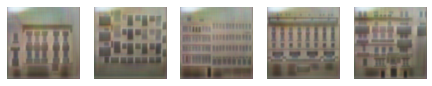

Epoch 7/50
12/12 [==============================] - 20s 2s/step - g_loss: 0.3557 - d_loss: 0.2905
Epoch 8/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3597 - d_loss: 0.2571
Epoch 9/50
12/12 [==============================] - 20s 2s/step - g_loss: 0.3602 - d_loss: 0.2595
Epoch 10/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3601 - d_loss: 0.2880
Epoch 11/50
12/12 [==============================] - 22s 2s/step - g_loss: 0.3578 - d_loss: 0.2754


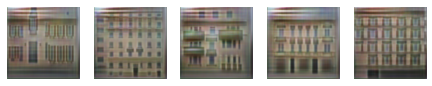

Epoch 12/50
12/12 [==============================] - 22s 2s/step - g_loss: 0.3596 - d_loss: 0.2389
Epoch 13/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3554 - d_loss: 0.2712
Epoch 14/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3536 - d_loss: 0.3711
Epoch 15/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3556 - d_loss: 0.2476
Epoch 16/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3536 - d_loss: 0.2269


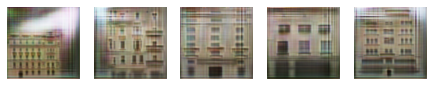

Epoch 17/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3522 - d_loss: 0.2402
Epoch 18/50
12/12 [==============================] - 20s 2s/step - g_loss: 0.3579 - d_loss: 0.2144
Epoch 19/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3517 - d_loss: 0.3821
Epoch 20/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3464 - d_loss: 0.2430
Epoch 21/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3472 - d_loss: 0.2256


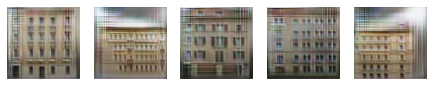

Epoch 22/50
12/12 [==============================] - 20s 1s/step - g_loss: 0.3425 - d_loss: 0.2875
Epoch 23/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3452 - d_loss: 0.2560
Epoch 24/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3418 - d_loss: 0.2557
Epoch 25/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3356 - d_loss: 0.3474
Epoch 26/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3350 - d_loss: 0.2525


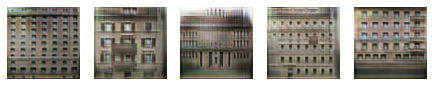

Epoch 27/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3344 - d_loss: 0.2690
Epoch 28/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3286 - d_loss: 0.2834
Epoch 29/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3327 - d_loss: 0.2571
Epoch 30/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3318 - d_loss: 0.2685
Epoch 31/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3251 - d_loss: 0.2847


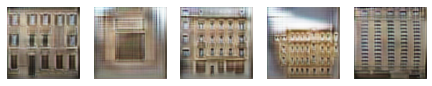

Epoch 32/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3244 - d_loss: 0.2741
Epoch 33/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3212 - d_loss: 0.2550
Epoch 34/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3194 - d_loss: 0.3256
Epoch 35/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3163 - d_loss: 0.2756
Epoch 36/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3195 - d_loss: 0.2564


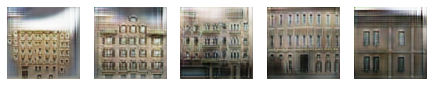

Epoch 37/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3195 - d_loss: 0.2925
Epoch 38/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3105 - d_loss: 0.2568
Epoch 39/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3112 - d_loss: 0.2588
Epoch 40/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3112 - d_loss: 0.2490
Epoch 41/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3073 - d_loss: 0.3163


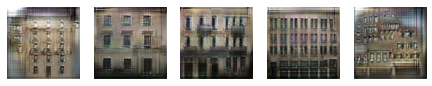

Epoch 42/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3035 - d_loss: 0.2651
Epoch 43/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3063 - d_loss: 0.2990
Epoch 44/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2973 - d_loss: 0.2510
Epoch 45/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.3019 - d_loss: 0.2473
Epoch 46/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2992 - d_loss: 0.4242


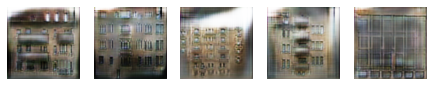

Epoch 47/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2969 - d_loss: 1.2047
Epoch 48/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2873 - d_loss: 0.2786
Epoch 49/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2874 - d_loss: 0.2796
Epoch 50/50
12/12 [==============================] - 21s 2s/step - g_loss: 0.2899 - d_loss: 0.2810


In [11]:
pix2pix = Pix2Pix(image_shape)
pix2pix.compile(Adam(2e-4, 0.5, 0.9999), Adam(2e-4, 0.5, 0.9999))

callbacks = [GenerativeCallback(test_dataset)]

pix2pix.fit(train_dataset, epochs=50, callbacks=callbacks)